In [199]:
# Import relevant libraries.
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob


# Ensure required NLTK resources are present (quiet=True => no console spam)
for pkg in [
    "punkt",
    "stopwords",
    "vader_lexicon",
]:
    nltk.download(pkg, quiet=True)

import warnings
warnings.filterwarnings("ignore")

In [200]:
# Load & initial tidy-up    

# Raw data set of central‑bank speeches
speeches = pd.read_csv("all_speeches.csv")

# Robust datetime parsing
speeches["date"] = pd.to_datetime(speeches["date"], errors="coerce")

# Period of interest: 1997‑01‑01 → 2022‑12‑31
speeches = speeches[speeches["date"].between("1997-01-01", "2022-12-31")]

In [201]:
# Basic Exploration
print("Dataset shape:", speeches.shape)
print("\nColumns:", speeches.columns.tolist())
print("\nFirst 5 rows of the data:")
speeches.head()

Dataset shape: (7665, 7)

Columns: ['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text']

First 5 rows of the data:


,reference,country,date,title,author,is_gov,text
36,r970205a_BOA,australia,1997-02-05,,macfarlane,1,When Alan Cameron invited me to speak at a con...
37,r970211a_BOA,australia,1997-02-11,,macfarlane,1,It is a great pleasure to be speaking at The S...
38,r970508a_BOA,australia,1997-05-08,,macfarlane,1,"Thank you, Mr Chairman. It is a pleasure for m..."
39,r970515a_BOA,australia,1997-05-15,,macfarlane,1,"It is a pleasure to be here in Melbourne, and ..."
40,r970812a_BOA,australia,1997-08-12,,macfarlane,1,It is a pleasure to be in Perth to address the...


In [202]:
# Data Validation
print("\nData types:")
print(speeches.dtypes)

print("\nMissing values per column:")
print(speeches.isnull().sum())


Data types:
reference            object
country              object
date         datetime64[ns]
title                object
author               object
is_gov                int64
text                 object
dtype: object

Missing values per column:
reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64


In [203]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches[speeches["country"].str.lower() == "united kingdom"].copy()
boe_speeches

,reference,country,date,title,author,is_gov,text
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased..."
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc..."
...,...,...,...,...,...,...,...
6165,r221007a_BOE,united kingdom,2022-10-07,"Shocks, inflation, and the policy response",ramsden,0,Thank you very much for the invitation to spea...
6166,r221012a_BOE,united kingdom,2022-10-12,Monetary policy: an anchor in challenging times,pill,0,Huw Pill talks about how we will bring inflati...
6167,r221015a_BOE,united kingdom,2022-10-15,Monetary policy and financial stability interv...,bailey,1,We are meeting in the most difficult of times....
6168,r221019a_BOE,united kingdom,2022-10-19,"Governance of “Decentralised” Finance: Get up,...",wilkins,0,"These are divided into seven categories, suffr..."


In [204]:
# Clean columns
boe_speeches["author"] = boe_speeches["author"].fillna("").str.strip()
boe_speeches["is_gov"] = 0  # Default: not a governor

# Edward George: 01‑Jul‑1993 → 30‑Jun‑2003
mask_george = (
    boe_speeches["author"].str.lower().str.contains("george")
    & (boe_speeches["date"] >= "1993-07-01")
    & (boe_speeches["date"] <= "2003-06-30")
)
boe_speeches.loc[mask_george, "is_gov"] = 1

# Mervyn King: 01‑Jul‑2003 → 30‑Jun‑2013
mask_king = (
    boe_speeches["author"].str.lower().str.contains("king")
    & (boe_speeches["date"] >= "2003-07-01")
    & (boe_speeches["date"] <= "2013-06-30")
)
boe_speeches.loc[mask_king, "is_gov"] = 1

# Mark Carney: 01‑Jul‑2013 → 15‑Mar‑2020
mask_carney = (
    boe_speeches["author"].str.lower().str.contains("carney")
    & (boe_speeches["date"] >= "2013-07-01")
    & (boe_speeches["date"] <= "2020-03-15")
)
boe_speeches.loc[mask_carney, "is_gov"] = 1

# Andrew Bailey: 16‑Mar‑2020 → present
mask_bailey = (
    boe_speeches["author"].str.lower().str.contains("bailey")
    & (boe_speeches["date"] >= "2020-03-16")
)
boe_speeches.loc[mask_bailey, "is_gov"] = 1

In [205]:
boe_speeches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1209 entries, 4961 to 6169
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   reference  1209 non-null   object        
 1   country    1209 non-null   object        
 2   date       1209 non-null   datetime64[ns]
 3   title      1209 non-null   object        
 4   author     1209 non-null   object        
 5   is_gov     1209 non-null   int64         
 6   text       1209 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 75.6+ KB


In [206]:
boe_speeches["is_gov"].value_counts()

is_gov
0    1015
1     194
Name: count, dtype: int64

In [207]:
boe_speeches[boe_speeches["is_gov"] == 1]["author"].value_counts()
boe_speeches

,reference,country,date,title,author,is_gov,text
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased..."
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc..."
...,...,...,...,...,...,...,...
6165,r221007a_BOE,united kingdom,2022-10-07,"Shocks, inflation, and the policy response",ramsden,0,Thank you very much for the invitation to spea...
6166,r221012a_BOE,united kingdom,2022-10-12,Monetary policy: an anchor in challenging times,pill,0,Huw Pill talks about how we will bring inflati...
6167,r221015a_BOE,united kingdom,2022-10-15,Monetary policy and financial stability interv...,bailey,1,We are meeting in the most difficult of times....
6168,r221019a_BOE,united kingdom,2022-10-19,"Governance of “Decentralised” Finance: Get up,...",wilkins,0,"These are divided into seven categories, suffr..."


In [208]:
# Splitting "date" & identify lenght speech    
boe_speeches["year"] = boe_speeches["date"].dt.year
boe_speeches["month"] = boe_speeches["date"].dt.month
boe_speeches["speech_length"] = boe_speeches["text"].str.split().apply(len)
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998,10,2311
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452


In [209]:
# Text Pre-processing (clean & tokenise)

STOP_WORDS = set(stopwords.words("english"))

def clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\d+", " ", text.lower())  # drop numerals
    text = re.sub(r"[^\w\s]", " ", text)     # drop punctuation
    tokens = [t for t in word_tokenize(text) if t not in STOP_WORDS]
    return " ".join(tokens)

boe_speeches["cleaned_text"] = boe_speeches["text"].apply(clean)

boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,cleaned_text
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,thank chairman actually pleased opportunity re...
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,great pleasure beautiful city bruges honoured ...
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998,10,2311,industries suffered volatility british economy...
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,topic evening use forecasts economic policy ma...
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,six years ago week sterling left exchange rate...


In [210]:
# Lexicon-based sentiment 

sentiment_lexicon = pd.read_excel("LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist-2.xlsx")
categories = [
     "Negative",
     "Positive",
     "Uncertainty",
     "Litigious",
     "Strong",
     "Weak",
     "Constraining",
 ]
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, "Word"].str.lower())
    for cat in categories
}

def lexicon_counts(text: str) -> pd.Series:
    tokens = re.findall(r"\b\w+\b", str(text).lower())
    return pd.Series({cat: sum(t in word_sets[cat] for t in tokens) for cat in categories})

boe_speeches = pd.concat(
    [boe_speeches, boe_speeches["text"].apply(lexicon_counts)], axis=1
 )
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,cleaned_text,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,thank chairman actually pleased opportunity re...,63,39,24,3,20,16,2
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,great pleasure beautiful city bruges honoured ...,87,82,52,6,39,30,16
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998,10,2311,industries suffered volatility british economy...,61,33,49,2,11,17,5
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,topic evening use forecasts economic policy ma...,78,43,92,11,31,42,15
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,six years ago week sterling left exchange rate...,102,46,119,22,20,49,12


In [211]:
# Vader 
sia = SentimentIntensityAnalyzer()
vader_scores = boe_speeches["cleaned_text"].apply(sia.polarity_scores).apply(pd.Series)
boe_speeches = pd.concat([boe_speeches, vader_scores], axis=1)

boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,...,Positive,Uncertainty,Litigious,Strong,Weak,Constraining,neg,neu,pos,compound
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,...,39,24,3,20,16,2,0.140,0.688,0.172,0.9952
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,...,82,52,6,39,30,16,0.100,0.679,0.221,0.9998
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998,10,2311,...,33,49,2,11,17,5,0.107,0.717,0.176,0.9977
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,...,43,92,11,31,42,15,0.070,0.780,0.150,0.9996
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,...,46,119,22,20,49,12,0.090,0.774,0.135,0.9990


In [212]:
# Sentiment per year
vader_yearly = (
    boe_speeches
      .groupby('year')[['compound', 'pos', 'neg', 'neu']]
      .mean()
      .round(3)           
                  
)

print("\nAverage VADER sentiment per year:")
vader_yearly


Average VADER sentiment per year:


,compound,pos,neg,neu
year,,,,
1998,0.997,0.168,0.108,0.723
1999,0.932,0.176,0.099,0.725
2000,0.944,0.205,0.087,0.708
2001,0.943,0.182,0.104,0.714
2002,0.930,0.194,0.106,0.700
2003,0.788,0.181,0.102,0.717
2004,0.858,0.173,0.092,0.734
2005,0.995,0.166,0.091,0.743
2006,0.823,0.172,0.097,0.731


In [213]:
def label_vader(c, thr=0.1):  # Use 0.1 instead of 0.05
    if c > thr:
        return "Positive"
    if c < -thr:
        return "Negative"
    return "Neutral"


In [214]:
boe_speeches["Sentiment Label (VADER)"] = boe_speeches["compound"].apply(label_vader)
print(boe_speeches["Sentiment Label (VADER)"].value_counts())


Sentiment Label (VADER)
Positive    1067
Negative     142
Name: count, dtype: int64


In [215]:
neutral_range = boe_speeches[(boe_speeches["compound"] >= -0.05) & (boe_speeches["compound"] <= 0.05)]
print(f"Speeches in neutral range (-0.05 to 0.05): {len(neutral_range)}")


Speeches in neutral range (-0.05 to 0.05): 0


In [216]:
def label_vader(c, thr=0.05):
    if c >  thr:
        return "Positive"
    if c < -thr:
        return "Negative"
    return "Neutral"

boe_speeches["Sentiment Label (VADER)"] = boe_speeches["compound"].apply(label_vader)
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,...,Uncertainty,Litigious,Strong,Weak,Constraining,neg,neu,pos,compound,Sentiment Label (VADER)
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,...,24,3,20,16,2,0.140,0.688,0.172,0.9952,Positive
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,...,52,6,39,30,16,0.100,0.679,0.221,0.9998,Positive
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998,10,2311,...,49,2,11,17,5,0.107,0.717,0.176,0.9977,Positive
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,...,92,11,31,42,15,0.070,0.780,0.150,0.9996,Positive
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,...,119,22,20,49,12,0.090,0.774,0.135,0.9990,Positive


In [217]:
boe_speeches[['year', 'Sentiment Label (VADER)']].head()

,year,Sentiment Label (VADER)
4961,1998,Positive
4962,1998,Positive
4963,1998,Positive
4964,1998,Positive
4965,1998,Positive


In [218]:
# Textblob Polarity & subjectivity.
def generate_polarity_subjectivity(dfs):
    dft2 = TextBlob(dfs).sentiment
    return pd.Series([dft2[0], dft2[1]])

# Apply the function to the data and add two new columns
boe_speeches[['polarity','subjectivity']] = boe_speeches['text'].apply(generate_polarity_subjectivity)
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,...,Strong,Weak,Constraining,neg,neu,pos,compound,Sentiment Label (VADER),polarity,subjectivity
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,...,20,16,2,0.140,0.688,0.172,0.9952,Positive,0.083288,0.435206
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,...,39,30,16,0.100,0.679,0.221,0.9998,Positive,0.076868,0.368726
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,0,Few industries have suffered more from volatil...,1998,10,2311,...,11,17,5,0.107,0.717,0.176,0.9977,Positive,0.091432,0.394993
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,...,31,42,15,0.070,0.780,0.150,0.9996,Positive,0.086707,0.476692
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,...,20,49,12,0.090,0.774,0.135,0.9990,Positive,0.058314,0.393456


In [219]:
# TextBlob  (polarity & subjectivity) per year
tb_yearly = (
    boe_speeches
        .groupby("year")[["polarity", "subjectivity"]]   
        .mean()                                          
        .round(3)                                        
)

print("\nAverage TextBlob polarity & subjectivity per year:")
tb_yearly


Average TextBlob polarity & subjectivity per year:


,polarity,subjectivity
year,,
1998,0.082,0.415
1999,0.091,0.407
2000,0.118,0.428
2001,0.099,0.421
2002,0.101,0.420
2003,0.098,0.417
2004,0.087,0.412
2005,0.093,0.429
2006,0.090,0.413


In [220]:
# Visualisations

# Speech count per year
fig1 = px.histogram(
    boe_speeches,
    x="year",
    nbins=23,
    title="Number of Bank of England speeches per year (1997–2022)",
)
fig1.update_layout(bargap=0.2)
 
fig1.show()

In [221]:
# Average speech length per year
length_by_year = (
     boe_speeches.groupby("year")["speech_length"].mean().reset_index()
)
fig2 = px.line(
     length_by_year,
     x="year",
     y="speech_length",
     title="Average speech length – Bank of England (2000–2022)",
     labels={"speech_length": "Words"},
)
fig2.update_traces(mode="lines+markers")
fig2.show()

In [222]:
# Normalized sentiment columns (per word)
for cat in categories:
    boe_speeches[f"{cat}_norm"] = boe_speeches[cat] / boe_speeches["speech_length"]

# Normalized columns (per word/speech length)
categories_norm = [f"{cat}_norm" for cat in categories]

# Average per year
lexicon_yearly = boe_speeches.groupby("year")[categories_norm].mean().reset_index()

# Plot the categories
fig3 = px.line(
    lexicon_yearly,
    x="year",
    y=["Uncertainty_norm", "Negative_norm", "Positive_norm"],
    title="Lexicon-based sentiment trends over time (BoE Speeches)",
    labels={"value": "Normalized score", "variable": "Sentiment Category"},
)
fig3.update_traces(mode="lines+markers")
fig3.show()

# Adding important events
fig3.add_vline(x=2008, line_dash="dot", line_color="red", annotation_text="Global Financial Crisis", annotation_position="top left")
fig3.add_vline(x=2016, line_dash="dot", line_color="orange", annotation_text="Brexit Vote", annotation_position="top left")
fig3.add_vline(x=2020, line_dash="dot", line_color="green", annotation_text="COVID-19", annotation_position="top left")
fig3.show()

#### ***Note: While we could include other categories such as "Litigious," "Strong," "Weak," and "Constraining", the categories "Positive," "Negative," and "Uncertainty" are more relevant and meaningful for our analysis, both in terms of interpretability and alignment with the study’s objectives. However, feel free to add them.***

The chart shows how normalized sentiment in Bank of England speeches has changed over time, reflecting key economic events:

* **Negative sentiment** peaks sharply during the 2008 financial crisis and remains elevated through much of the 2010s before gradually declining.

* **Positive sentiment** is highest in the early years (1998–2000) but stays low and stable afterward.

* **Uncertainty** rises moderately during Brexit (2016) and COVID-19 (2020), with a noticeable spike in the early 2000s.

The timing of sentiment shifts aligns with major events, suggesting that the Bank’s communication tone becomes more negative or uncertain during periods of economic stress.

In [225]:
# Average VADER sentiment per year
vader_yearly = boe_speeches.groupby("year")[["pos", "neg", "neu", "compound"]].mean().reset_index()
fig4 = px.line(
     vader_yearly,
     x="year",
     y=["pos", "neg", "neu", "compound"],
     title="Average VADER sentiment scores – Bank of England speeches (1997–2022)",
     labels={"value": "Average score", "variable": "Metric"},
)
fig4.update_traces(mode="lines+markers")
fig4.show()

The full-panel VADER plot provides a more detailed decomposition of the Bank’s language. Across the entire 1997–2022 period, the neutral share (green) hovers close to 0.70—clear evidence that most of the Bank’s speech content remains informational, as expected from a central bank tasked with projecting authority and clarity. 

(Note: In the VADER framework, “neutral” refers to the proportion of neutral words in the text—not a final sentiment label. This explains why the compound score can be strongly positive even when the neutral share dominates.) Within the remaining 30% of “sentiment-bearing” content, the positive share (blue, ≈ 0.16–0.21) consistently outweighs the negative share (red, ≈ 0.09–0.12), resulting in a strongly positive compound score (violet) that rarely falls below 0.50.

Notably, the few downward movements in the compound score align precisely with major stress episodes highlighted in the project brief: an initial decline in 2008–09 during the global financial crisis, a second dip in 2011–12 amid euro-area tensions, and the most pronounced drop in 2020 at the onset of the COVID-19 shock. In each case, the Bank’s tone became noticeably less upbeat (reflected in falling compound scores and rising negative shares), yet the neutral component remained dominant—signaling the Bank’s ongoing commitment to anchoring expectations through factual, measured communication. 

The rapid sentiment rebounds in 2013–14 and again in 2021 further illustrate how the Bank modulates its tone upward as soon as macro-financial conditions begin to stabilise. Together, these patterns reinforce the institution’s role in reassuring markets while supporting the United Kingdom’s monetary and financial stability.

In [227]:
# Count total sentiment labels
total_sentiments = boe_speeches["Sentiment Label (VADER)"].value_counts().reset_index()
total_sentiments.columns = ["Sentiment", "Count"]

# Plot with custom colors for each sentiment category
fig_total_sent = px.bar(
    total_sentiments,
    x="Sentiment",
    y="Count",
    color="Sentiment",  
    color_discrete_map={
        "Positive": "#4CAF50",   
        "Negative": "#F44336",   
        "Neutral": "#2196F3"     
    },
    title="Total Count of Sentiments in Bank of England Speeches (1997–2022)",
    labels={"Sentiment": "Sentiment Category", "Count": "Total Speeches"},
    height=600,
    width=700
)

fig_total_sent.show()

The bar chart summarises the final sentiment classifications of Bank of England speeches from 1997 to 2022 based on VADER’s compound score and a ±0.05 threshold. Out of the full sample, over 1,000 speeches were labeled as “Positive”, and roughly 140 as “Negative”—with no speeches classified as “Neutral.”

This striking imbalance is not due to an error or data gap, but rather a consequence of how the VADER model behaves when applied to formal, institutional language. As earlier plots show, the compound scores are typically well above 0.05, due to a consistent surplus of positive over negative language, even in otherwise neutral or balanced texts. The absence of "Neutral" labels occurs because very few speeches fall within the narrow neutral band of –0.05 to +0.05.

Importantly, this does not mean the Bank’s speeches lack neutrality in tone. In fact, as demonstrated in the full VADER component breakdown, the neutral word share consistently hovers around 70%, indicating that most content is factual or descriptive. However, the compound scoring formula—designed for shorter, emotion-rich texts—amplifies even mild positive phrasing, leading to inflated sentiment classifications.

In [229]:
# Plot with Compound and Events 
fig4 = px.line(
    vader_yearly,
    x="year",
    y="compound",
    title="Average VADER compound sentiment – BoE Speeches (1997–2022)",
    labels={"compound": "Compound Sentiment", "year": "Year"}
)
fig4.update_traces(mode="lines+markers")
# Add event lines
fig4.add_vline(x=2008, line_dash="dot", line_color="red", annotation_text="Global Financial Crisis")
fig4.add_vline(x=2016, line_dash="dot", line_color="orange", annotation_text="Brexit Vote")
fig4.add_vline(x=2020, line_dash="dot", line_color="green", annotation_text="COVID-19")
fig4.show()

This chart displays the average VADER compound sentiment of Bank of England speeches from 1997 to 2022, with major events highlighted.

* The overall tone of speeches remains strongly positive before 2008, with average compound scores close to 1.0, indicating consistently optimistic language.

* A noticeable decline occurs during the 2008 Global Financial Crisis, with sentiment dropping significantly, reflecting a more cautious or negative communication style.

* Sentiment compound recovers after 2010 but shows more volatility in the following years.

* Around the 2016 Brexit referendum, sentiment dips again, though not as sharply.

* A steep decline is observed in 2020, aligning with the COVID-19 pandemic, where the compound score reaches its lowest point in the time series, indicating a highly negative or uncertain tone.

* Post-COVID, sentiment shows some rebound but remains lower than pre-2008 levels.

This trend supports the idea that VADER sentiment scores reflect the Bank’s shifting tone in response to external crises, offering a useful general-purpose measure alongside lexicon-based sentiment.

In [231]:
#polarity
fig_polarity = px.line(
    tb_yearly.reset_index(),  # <-- fix here
    x="year",
    y="polarity",
    title="Average TextBlob Polarity – Bank of England Speeches",
    labels={"polarity": "Average Polarity", "year": "Year"}
)
fig_polarity.update_traces(mode="lines+markers")
fig_polarity.show()

#subjectivity
fig_subjectivity = px.line(
    tb_yearly.reset_index(),
    x="year",
    y="subjectivity",
    title="Average TextBlob Subjectivity – Bank of England Speeches",
    labels={"subjectivity": "Average Subjectivity", "year": "Year"}
)

fig_subjectivity.update_traces(mode="lines+markers", line_color="red")

fig_subjectivity.show()

**Average Polarity:**
Polarity measures sentiment on a scale from -1 (very negative) to +1 (very positive). All values here are positive but relatively low, meaning the language in the speeches is generally mildly positive or neutral-positive.

<u>Key patterns:</u>
- 1999–2000 peak: A noticeable spike around 2000 suggests more optimistic or confident tone in that period, possibly reflecting economic stability or growth.

- 2005–2010 dip: A downward trend in polarity leading up to and during the global financial crisis (2008–2009) suggests a more cautious or negative tone.

- 2013–2019 steady rise: This increase could reflect economic recovery and market confidence during that time.

- Post-2019 dip: The drop after 2019 might correspond to rising uncertainty (e.g., Brexit, COVID-19 pandemic).

**Average Subjectivity:**
Subjectivity ranges from 0 (completely objective) to 1 (highly subjective). The scores here are moderate (~0.41–0.43), indicating a mostly objective tone, but with some variation.

<u>Key patterns:</u>
- 2000 & 2005 peaks: The BoE may have used more interpretive or advisory language during these years, perhaps around changes in monetary policy.

- 2007–2010 flattening: During the crisis years, speeches became slightly more factual and measured — lower subjectivity could reflect a deliberate tone of authority and control.

- Stable trend from 2011–2021: The subjectivity level remains relatively steady, suggesting consistent communication style.

***Combined insight:***

* There is a mild correlation between subjectivity and polarity: when sentiment becomes more optimistic (higher polarity), speeches also tend to become slightly more subjective (e.g., 2000, 2005).

* However, both remain within moderate ranges, showing that the BoE maintains a balanced, measured tone in its public communications — even during volatile periods.

In [233]:
# Polarity & subjectivity 
fig_tb_combo = px.line(
    tb_yearly.reset_index(),            
    x="year",
    y=["polarity", "subjectivity"],
    title="Average TextBlob polarity and subjectivity – Bank of England speeches",
    labels={"value": "Average score", "variable": "Metric", "year": "Year"},
)
fig_tb_combo.update_traces(mode="lines+markers")
fig_tb_combo.show()

The TextBlob results confirm that, in fulfilling its mandate to “promote the good of the people of the United Kingdom by maintaining monetary and financial stability,” the Bank of England adopts a remarkably steady rhetorical stance. Average polarity (blue line) stays modestly positive—between ≈ 0.08 and 0.11—for the entire 1997-2022 sample, signalling a deliberately reassuring tone that fits the Bank’s role as an anchor for market expectations. The small but clear troughs in 2001-03 (post-dot-com slowdown), 2008-12 (global-financial and euro-area crises) and 2020 (COVID-19 shock) show that even this cautious measure registers periods of heightened concern, before rebounding as conditions stabilise—evidence that the Bank’s communications react to macro-financial stress but avoid excessive pessimism.

***(Note: In the combined chart, the y-axis is fixed to a common 0.0–0.5 scale to allow direct visual comparison between polarity and subjectivity levels, despite their differing magnitudes.)***


By contrast, subjectivity (orange line) hovers narrowly around 0.40-0.43 throughout. In practical terms this means that roughly 60 % of each speech is factual or data-driven while the remaining 40 % contains interpretative or forward-looking statements. The near-flat profile—barely affected by the crises noted above—suggests that, whatever the economic backdrop, the Bank maintains a consistent mix of analysis and judgement in its public messaging. This stylistic stability is fully aligned with its strategic objective: to provide markets and households with dependable guidance, neither overly technical nor unduly emotive, thereby supporting monetary-policy credibility and overall financial stability.

In [235]:
# Compound and Polarity 
combo = vader_yearly.merge(tb_yearly, on="year")

fig_combo = px.line(
    combo,
    x="year",
    y=["compound", "polarity"],
    title="VADER compound vs TextBlob polarity – Bank of England speeches",
    labels={"value": "Average score", "variable": "Metric"}
)
fig_combo.update_traces(mode="lines+markers")
fig_combo.show()

The combined plot of VADER compound (blue) and TextBlob polarity (red) summarises how the overall tone of Bank-of-England speeches has evolved since 1998. Although the two indices are reported on the same vertical axis, their scales differ: VADER’s non-linear formula pushes values close to +1 whenever positive language dominates, whereas TextBlob remains tightly compressed (≈ 0.07–0.12). For that reason we interpret the curves in terms of directional changes, not absolute height.

Both series move in lock-step: plateaus at high levels through the late-1990s and early-2000s; an unmistakable dip during the global-financial crisis (2007-09); a second trough in 2011-12 as euro-area turmoil intensified; and a sharp collapse in 2020 at the onset of the Covid-19 shock, followed by an incomplete rebound in 2021-22. The fact that the “quiet” polarity line tracks every rise and fall in the more volatile compound line confirms that the signal is real rather than a model artefact. In practical terms, VADER offers a high-resolution “early-warning” indicator, while TextBlob provides a stable baseline for long-run trend analysis. Taken together, the two metrics show that the Bank consistently adopts a mildly positive tone, yet still modulates that tone noticeably in response to major episodes of macro-financial stress, exactly as one would expect from an institution whose communications are meant to reassure markets while reflecting underlying economic realities.

In [237]:
# Mean sentiment scores grouped by is_gov
avg_sentiment = (
    boe_speeches
    .groupby("is_gov")[["compound", "polarity", "Positive_norm", "Negative_norm", "Uncertainty_norm"]]
    .mean()
    .reset_index()
)

# Map to role and drop 'is_gov' before melting
avg_sentiment["Role"] = avg_sentiment["is_gov"].map({1: "Governor", 0: "Non-Governor"})
avg_sentiment = avg_sentiment.drop(columns="is_gov")

# Melt for plotting
melted = avg_sentiment.melt(id_vars="Role", var_name="Metric", value_name="Score")

# Plot
fig_avg_sent = px.bar(
    melted,
    x="Metric",
    y="Score",
    color="Role",
    barmode="group",
    title="Average Sentiment Scores – Governor vs Non-Governor Speeches",
    height=500
)
fig_avg_sent.show()

This chart compares the average sentiment scores across speeches given by governors and non-governors of the Bank of England.

* Governors show higher compound and polarity scores, indicating a more consistently positive and confident tone in their speeches.

* Lexicon-based sentiment (positive, negative, uncertainty) is very similar across both groups, but governors exhibit slightly more positivity and less uncertainty.

* The lower sentiment scores among non-governors suggest a tone that may be more analytical, cautious, or varied depending on the role and context.

These differences reflect the governor’s institutional role in projecting stability, while non-governors may offer more technical or critical perspectives.

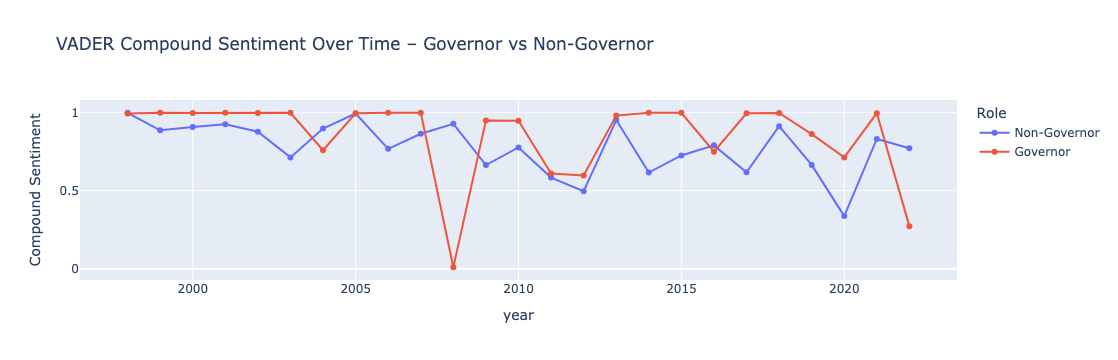

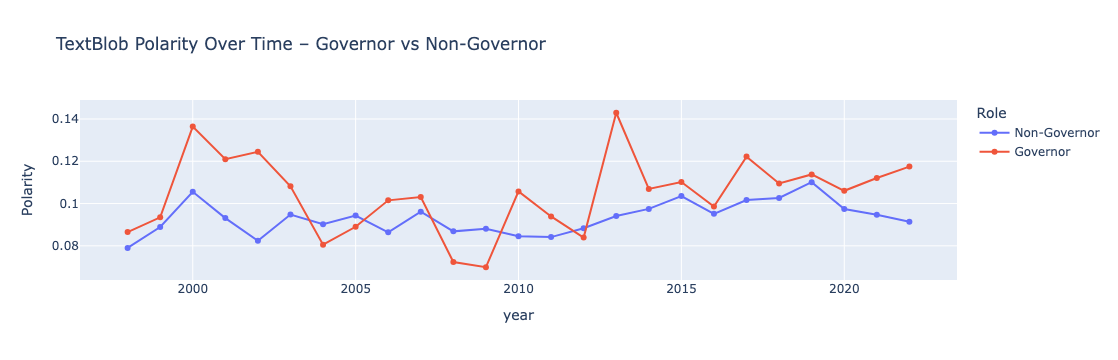

In [241]:
# Group by year and is_gov plus compound
by_year_role = (
    boe_speeches
    .groupby(["year", "is_gov"])["compound"]
    .mean()
    .reset_index()
)
by_year_role["Role"] = by_year_role["is_gov"].map({1: "Governor", 0: "Non-Governor"})

#Vader compound score
fig_gov = px.line(
    by_year_role,
    x="year",
    y="compound",
    color="Role",
    title="VADER Compound Sentiment Over Time – Governor vs Non-Governor",
    markers=True,
    labels={"compound": "Compound Sentiment"},
)
fig_gov.show()


# Group by year and is_gov plus polarity
by_year_role_tb = (
    boe_speeches
    .groupby(["year", "is_gov"])[["polarity"]]
    .mean()
    .reset_index()
)

by_year_role_tb["Role"] = by_year_role_tb["is_gov"].map({1: "Governor", 0: "Non-Governor"})

fig_pol = px.line(
    by_year_role_tb,
    x="year",
    y="polarity",
    color="Role",
    markers=True,
    title="TextBlob Polarity Over Time – Governor vs Non-Governor",
    labels={"polarity": "Polarity"}
)

fig_pol.show()

A role-based comparison of sentiment over time reveals a clear pattern: Governors consistently speak with greater optimism than Non-Governors, regardless of which sentiment model is used. In both TextBlob and VADER, the Governor curve remains elevated, reflecting their function as public-facing communicators responsible for reassuring markets and signaling policy direction. By contrast, Non-Governor speeches, likely focused on analysis and operational details, maintain a flatter tone.

While TextBlob polarity shows steady, moderate differences, VADER’s compound score exhibits greater volatility, particularly in Governor speeches. These sharp dips (e.g. 2009, 2022) suggest that VADER may overemphasize subtle shifts in tone, especially when applied to formal language. Nevertheless, the consistent leadership of Governor sentiment across both models reinforces the Bank of England’s strategic use of communication to manage expectations and preserve stability.

### Conclusion:
The combined analysis of lexicon-based, VADER, and TextBlob sentiment metrics reveals a clear and consistent pattern:

* The Bank of England adjusts the tone of its public communications in response to major economic disruptions, adopting a more negative and uncertain sentiment during periods such as the 2008 global financial crisis, the euro-area tensions in 2011–2012, the 2016 Brexit referendum, and the 2020 COVID-19 pandemic.

* While VADER captures overall tone shifts with high sensitivity, the lexicon-based method highlights changes in specific emotional dimensions like uncertainty and negativity, and TextBlob confirms a steady but responsive rhetorical baseline. Together, these tools show that the Bank's speeches remain largely neutral and informative—as expected from a central bank—but do exhibit noticeable tonal adjustments that reflect macro-financial stress.

* Importantly, speeches delivered by governors tend to exhibit consistently higher and more stable sentiment, reinforcing their role in projecting confidence and institutional stability. In contrast, non-governor speeches are more volatile and often reflect sharper sentiment declines during crises, offering a more analytical or reactive tone. This divergence likely reflects a purposeful communication structure: governors shape expectations through steady messaging, while non-governors provide critical economic context and risk insight. Together, their voices form a coordinated narrative that supports transparency, credibility, and macro-financial stability.

These results support the idea that BoE communications not only anchor market expectations but also react systematically to economic conditions, offering potential predictive value and insight into institutional sentiment.